# CHAPTER 14: _In Processing Methods_

## The Preparations

In [ ]:
# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Installing the Libraries

In [ ]:
%%capture
!pip install solas-ai
!pip install aif360
!pip install 'aif360[Reductions]'
!pip install 'aif360[inFairness]'

### Loading the Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2718)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay


import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

from aif360.sklearn.inprocessing import AdversarialDebiasing

from scipy.stats import ks_2samp

import solas_disparity as sd

import plotly.io as pio
pio.renderers.default = "png"

## Importing and Preparing the Data

In [ ]:
url = 'https://raw.githubusercontent.com/PacktPublishing/Building-Responsible-AI-with-Python/main/data/hmda.csv'
df = pd.read_csv(url, index_col=0)
df.drop(columns=['train'], inplace=True)
# AIF 360 cannot handle missing values for protected class so we are only going to use Black and white applicants:
df = df.loc[(df['black'] == 1) | (df['white'] == 1), :]

In [ ]:
df

,cv_fold,high_priced,low_priced,interest_rate,rate_spread,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio_original,debt_to_income_ratio,term_360,conforming,state,state_target_encoded,product_type,product_type_conventional,product_type_fha,product_type_fsa_rhs,product_type_va,black,asian,white,native_american,hawaiian_or_pacific_islander,hispanic,non_hispanic,male,female,agegte62,agelt62,race,ethnicity,sex
1879906,NaN,0.0,1.0,0.04875,0.00996,55000.0,1.01010,1,0,55000.0,36000.0,20%-<30%,0.25,1.0,1.0,MS,0.087045,fsa_rhs,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,White,Non-Hispanic,Female
1862043,3.0,0.0,1.0,0.04875,0.00681,265000.0,1.00000,1,0,265000.0,102000.0,36,0.36,1.0,1.0,SC,0.090457,conventional,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,White,Non-Hispanic,Female
4589390,NaN,0.0,1.0,0.03750,-0.00206,395000.0,0.80000,1,0,485000.0,200000.0,49,0.49,1.0,1.0,TX,0.172242,conventional,1,0,0,0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,White,Unknown,Unknown
5234032,2.0,0.0,1.0,0.04625,0.00296,135000.0,0.57854,1,0,235000.0,59000.0,20%-<30%,0.25,1.0,1.0,TX,0.172242,conventional,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,White,Non-Hispanic,Female
4323290,4.0,0.0,1.0,0.04500,0.00298,365000.0,0.90000,1,0,415000.0,176000.0,30%-<36%,0.33,1.0,1.0,TX,0.172242,conventional,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4937160,5.0,0.0,1.0,0.04625,0.00304,455000.0,0.89723,1,0,505000.0,142000.0,30%-<36%,0.33,1.0,1.0,UT,0.097009,conventional,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown
41834,1.0,0.0,1.0,0.02990,0.00953,305000.0,0.74390,0,12,415000.0,153000.0,30%-<36%,0.33,1.0,1.0,KY,0.087719,conventional,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown
3790562,1.0,1.0,0.0,0.04500,0.01533,305000.0,0.96500,1,0,305000.0,113000.0,49,0.49,1.0,1.0,IN,0.119708,fha,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown
4280451,NaN,0.0,1.0,0.04750,0.00342,165000.0,0.31370,1,0,515000.0,65000.0,41,0.41,1.0,1.0,NJ,0.065950,conventional,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown


In [ ]:
df.loc[:, 'black'] = df['black'].astype(int)
df.loc[:, 'white'] = df['white'].astype(int)
df.set_index('black', inplace=True, append=True, drop=False)

In [ ]:
log_features = ['loan_amount', 'property_value', 'income']
df.loc[:, log_features] = np.log(df[log_features].clip(1))

In [ ]:

train, vs = train_test_split(df, test_size=0.3, random_state=618)
valid, scale = train_test_split(vs, test_size=0.15, random_state=3)
print(train.shape, valid.shape, scale.shape)

(164890, 36) (60067, 36) (10601, 36)


In [ ]:
label = 'low_priced'
features = [
    'loan_amount', 'loan_to_value_ratio', 'no_intro_rate_period',
    'intro_rate_period', 'property_value', 'income',
    'debt_to_income_ratio', 'term_360', 'conforming',
    'state_target_encoded', 'product_type_conventional',
    'product_type_fha', 'product_type_fsa_rhs', 'product_type_va',
]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train[features])

MinMaxScaler()

In [ ]:
train[features] = scaler.transform(train[features])
valid[features] = scaler.transform(valid[features])
scale[features] = scaler.transform(scale[features])

In [ ]:
valid[features].agg(['min', 'max'])

,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,state_target_encoded,product_type_conventional,product_type_fha,product_type_fsa_rhs,product_type_va
min,0.000000,0.001153,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.914796,0.858185,1.0,1.0,0.85075,0.859571,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Create Helper Functions

In [ ]:
def make_dnn_preds(dnn_model, data):
    return pd.Series(
        data=dnn_model.predict_proba(data)[:, 1],
        index=data.index
    )

In [ ]:
def get_aucs(train_pred, valid_pred):
    auc_train = metrics.roc_auc_score(train[label], train_pred)
    auc_valid = metrics.roc_auc_score(valid[label], valid_pred)
    pct_change = auc_valid / auc_train - 1

    print(f'AUC Train:     {auc_train:.4f}')
    print(f'AUC Valid:     {auc_valid:.4f}')
    print(f'AUC % Change: {pct_change:.2%}')

In [ ]:
def get_logloss(train_pred, valid_pred):
    logloss_train = metrics.log_loss(train[label], train_pred)
    logloss_valid = metrics.log_loss(valid[label], valid_pred)
    pct_change = logloss_valid / logloss_train - 1

    print(f'Log-Loss Train:    {logloss_train:.4f}')
    print(f'Log-Loss Valid:    {logloss_valid:.4f}')
    print(f'Log-Loss % Change: {pct_change:.2%}')

In [ ]:
def get_race_logloss(train_pred, valid_pred):
    logloss_train = metrics.log_loss(train['black'], train_pred)
    logloss_valid = metrics.log_loss(valid['black'], valid_pred)

    print(f'Black Log-Loss Train:    {logloss_train:.4f}')
    print(f'Black Log-Loss Valid:    {logloss_valid:.4f}')

In [ ]:
def calculate_quantile_air(group_data, prediction):
    qair = sd.adverse_impact_ratio_by_quantile(
        group_data=group_data,
        protected_groups=['black'],
        reference_groups=['white'],
        group_categories=['Race'],
        air_threshold=0.90,
        percent_difference_threshold=0,
        outcome=prediction,
        quantiles=[x / 100 for x in range(5, 101, 5)],
        merge_bins=False,
        lower_score_favorable=False,
    )
    return qair

In [ ]:
def calculate_smd(group_data, prediction):
    smd = sd.standardized_mean_difference(
        group_data=group_data,
        protected_groups=['black'],
        reference_groups=['white'],
        group_categories=['Race'],
        smd_threshold=-30,
        outcome=prediction,
        lower_score_favorable=False,
    )
    smd_columns = [
        'Average Outcome', 'Difference in Average Outcome',
        'Std. Dev. of Outcomes', 'SMD', 'Practically Significant',
    ]

    return smd.summary_table[smd_columns]

In [ ]:
def build_model(params, calibration=False):
    dnn = AdversarialDebiasing(
        **params,
        prot_attr='black',
        random_state=61803,
    )
    dnn = dnn.fit(X=train[features], y=train[label])

    if calibration:
        calibrated_dnn = CalibratedClassifierCV(
            estimator=dnn,
            method='sigmoid',
            cv='prefit'
        )
        calibrated_dnn.fit(X=scale[features], y=scale[label])
        train_pred = make_dnn_preds(calibrated_dnn, train[features])
        valid_pred = make_dnn_preds(calibrated_dnn, valid[features])

    else:
        train_pred = make_dnn_preds(dnn, train[features])
        valid_pred = make_dnn_preds(dnn, valid[features])

    return dnn, train_pred, valid_pred

In [ ]:
def ks_plot(prediction, model_name):
    label_1 = prediction.loc[valid[label] == 1]
    label_0 = prediction.loc[valid[label] == 0]

    ks_statistic, p_value = ks_2samp(label_1, label_0)

    # Create KS plot
    fig, ax = plt.subplots()
    ax.plot(np.sort(label_1), np.linspace(0, 1, len(label_1), endpoint=False),
            label='True Low-Priced Loans')
    ax.plot(np.sort(label_0), np.linspace(0, 1, len(label_0), endpoint=False),
            label='True High-Priced Loans')
    ax.legend()
    plt.xlim(-0.05, 1.05)
    ax.set_xlabel('Probability of Being a Low-Priced Loan')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(f'KS Plot for {model_name} Model\nKS Statistic: {ks_statistic:.4f}, p-value: {p_value:.4f}')
    plt.show()

## Building the Baseline DNN Model

In [ ]:
base_params = dict(
    adversary_loss_weight=0,
    num_epochs=500,
    batch_size=1024,
    classifier_num_hidden_units=100,
    debias=False,
)
base_model, base_train_pred, base_valid_pred = build_model(base_params, True)

## Building the Adversarial De-Biasing Model

In [ ]:
adb_params = dict(
    adversary_loss_weight=3,
    num_epochs=500,
    batch_size=1024,
    classifier_num_hidden_units=100,
    debias=True,
)
adb_model, adb_train_pred, adb_valid_pred = build_model(adb_params, True)

## Testing and Comparing Model Quality for the Two DNNs

In [ ]:
# AUCs for the Baseline Model
get_aucs(base_train_pred, base_valid_pred)

In [ ]:
# AUCs for the ADB Model
get_aucs(adb_train_pred, adb_valid_pred)

AUC Train:     0.8822
AUC Valid:     0.8839
AUC % Change: 0.19%


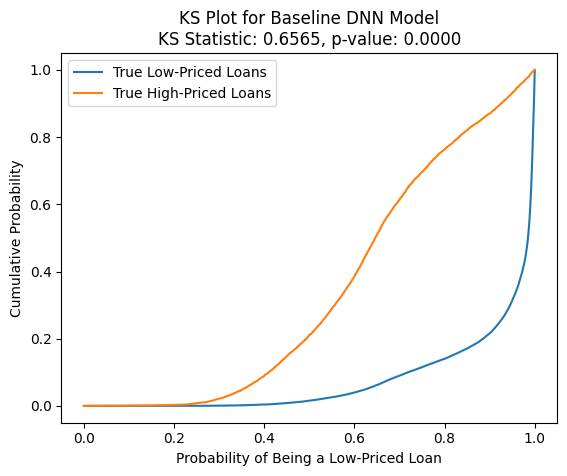

In [ ]:
ks_plot(base_valid_pred, 'Baseline DNN')

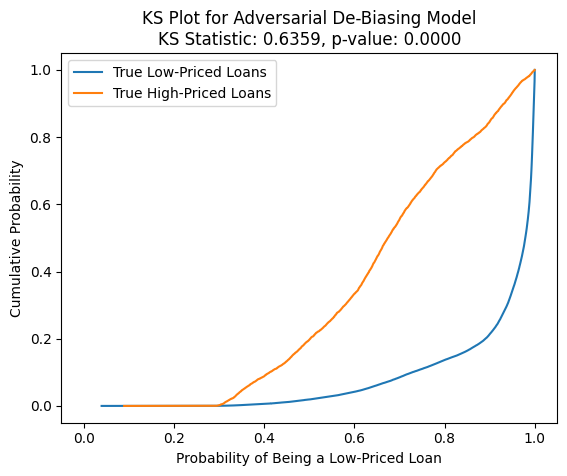

In [ ]:
ks_plot(adb_valid_pred, 'Adversarial De-Biasing')

## Testing the Effectiveness of the Adversary

In [ ]:
get_race_logloss(base_train_pred, base_valid_pred)

Black Log-Loss Train:    3.5207
Black Log-Loss Valid:    3.5342


In [ ]:
get_race_logloss(adb_train_pred, adb_valid_pred)

Black Log-Loss Train:    3.4388
Black Log-Loss Valid:    3.4507


## Calculating and Comparing Disparities for the Two DNNs



### Standardized Mean Differences (SMDs)

In [ ]:
base_smd = calculate_smd(valid, base_valid_pred)
base_smd

,Average Outcome,Difference in Average Outcome,Std. Dev. of Outcomes,SMD,Practically Significant
Group,,,,,
black,0.813922,-0.090544,0.15621,-57.962664,Yes
white,0.904465,NaN,0.15621,NaN,


In [ ]:
adb_smd = calculate_smd(valid, adb_valid_pred)
adb_smd

,Average Outcome,Difference in Average Outcome,Std. Dev. of Outcomes,SMD,Practically Significant
Group,,,,,
black,0.826703,-0.076953,0.152599,-50.428131,Yes
white,0.903656,NaN,0.152599,NaN,


### Adverse Impact Ratios (AIRs)

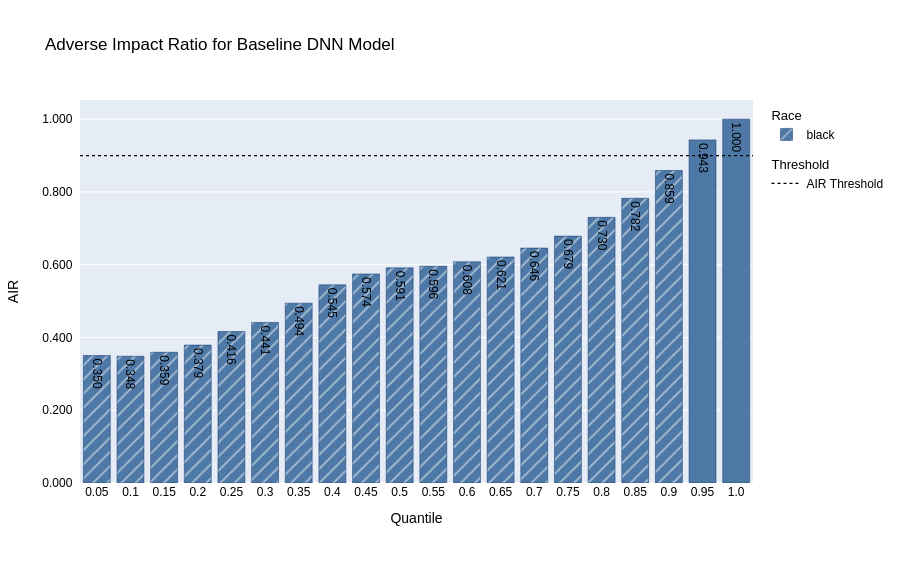

In [ ]:
base_air = calculate_quantile_air(valid, base_valid_pred)
fig = base_air.plot(group='black')
fig.update_layout(title='Adverse Impact Ratio for Baseline DNN Model')
fig.show()

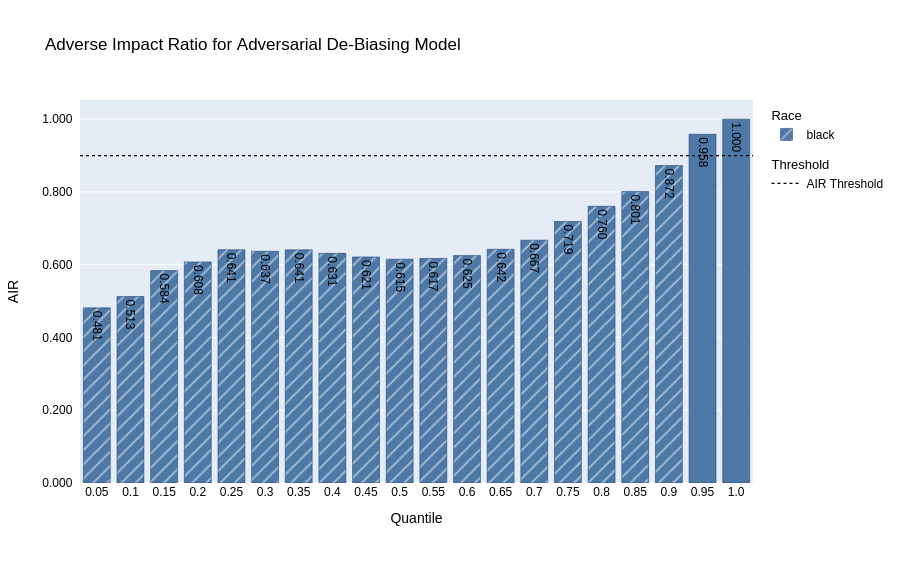

In [ ]:
adb_air = calculate_quantile_air(valid, adb_valid_pred)
fig = adb_air.plot(group='black')
fig.update_layout(title='Adverse Impact Ratio for Adversarial De-Biasing Model')
fig.show()

## Disparity Calculation: Adverse Impact Ratio By Quantile

┌───────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────┐
│ Protected Groups                                                                          │ black               │
│ Reference Groups                                                                          │ white               │
│ Group Categories                                                                          │ Race                │
│ AIR Threshold                                                                             │ 0.9                 │
│ Percent Difference Threshold                                                              │ 0.0                 │
│ Lower Score Favorable                                                                     │ False               │
│ Affected Groups                                                                           │ black               │
│ Affected Reference                                                                        │ white               │
│ Affected Categories                                                                       │ Race                │
└───────────────────────────────────────────────────────────────────────────────────────────┴─────────────────────┘

## Adverse Impact Ratio By Quantile Summary Table

Group,Quantile,Reference Group,Group Category,Quantile Cutoff,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant
black,5.0%,white,Race,9.991037e-01,"60,067",0.00%,"5,122.0",95.0,1.85%,3.44%,0.350,0.000,Yes
white,5.0%,,nan,9.991037e-01,"60,067",0.00%,"54,945.0","2,909.0",5.29%,,,,
black,10.0%,white,Race,9.978981e-01,"60,067",0.00%,"5,122.0",189.0,3.69%,6.90%,0.348,0.000,Yes
white,10.0%,,nan,9.978981e-01,"60,067",0.00%,"54,945.0","5,818.0",10.59%,,,,
black,15.0%,white,Race,9.966996e-01,"60,067",0.00%,"5,122.0",292.0,5.70%,10.17%,0.359,0.000,Yes
white,15.0%,,nan,9.966996e-01,"60,067",0.00%,"54,945.0","8,718.0",15.87%,,,,
black,20.0%,white,Race,9.954741e-01,"60,067",0.00%,"5,122.0",410.0,8.00%,13.11%,0.379,0.000,Yes
white,20.0%,,nan,9.954741e-01,"60,067",0.00%,"54,945.0","11,604.0",21.12%,,,,
black,25.0%,white,Race,9.941576e-01,"60,067",0.00%,"5,122.0",561.0,10.95%,15.36%,0.416,0.000,Yes
white,25.0%,,nan,9.941576e-01,"60,067",0.00%,"54,945.0","14,456.0",26.31%,,,,


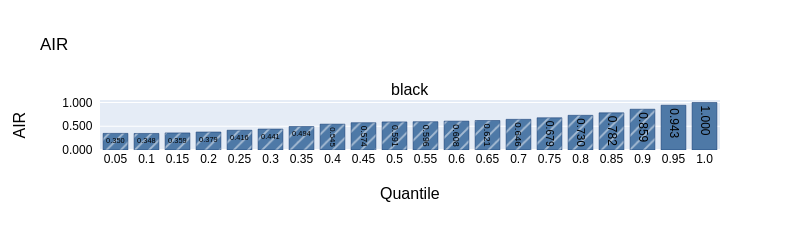

In [ ]:
base_air

## Disparity Calculation: Adverse Impact Ratio By Quantile

┌───────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────┐
│ Protected Groups                                                                          │ black               │
│ Reference Groups                                                                          │ white               │
│ Group Categories                                                                          │ Race                │
│ AIR Threshold                                                                             │ 0.9                 │
│ Percent Difference Threshold                                                              │ 0.0                 │
│ Lower Score Favorable                                                                     │ False               │
│ Affected Groups                                                                           │ black               │
│ Affected Reference                                                                        │ white               │
│ Affected Categories                                                                       │ Race                │
└───────────────────────────────────────────────────────────────────────────────────────────┴─────────────────────┘

## Adverse Impact Ratio By Quantile Summary Table

Group,Quantile,Reference Group,Group Category,Quantile Cutoff,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant
black,5.0%,white,Race,0.999254,"60,067",0.00%,"5,122.0",129.0,2.52%,2.71%,0.481,0.000,Yes
white,5.0%,,nan,0.999254,"60,067",0.00%,"54,945.0","2,875.0",5.23%,,,,
black,10.0%,white,Race,0.997882,"60,067",0.00%,"5,122.0",274.0,5.35%,5.08%,0.513,0.000,Yes
white,10.0%,,nan,0.997882,"60,067",0.00%,"54,945.0","5,733.0",10.43%,,,,
black,15.0%,white,Race,0.996394,"60,067",0.00%,"5,122.0",465.0,9.08%,6.47%,0.584,0.000,Yes
white,15.0%,,nan,0.996394,"60,067",0.00%,"54,945.0","8,545.0",15.55%,,,,
black,20.0%,white,Race,0.994924,"60,067",0.00%,"5,122.0",644.0,12.57%,8.12%,0.608,0.000,Yes
white,20.0%,,nan,0.994924,"60,067",0.00%,"54,945.0","11,370.0",20.69%,,,,
black,25.0%,white,Race,0.993339,"60,067",0.00%,"5,122.0",847.0,16.54%,9.25%,0.641,0.000,Yes
white,25.0%,,nan,0.993339,"60,067",0.00%,"54,945.0","14,170.0",25.79%,,,,


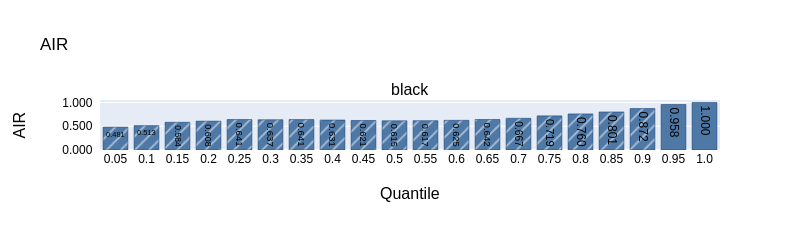

In [ ]:
adb_air

In [ ]:
air_compare = pd.concat(
    objs=(
        base_air.summary_table['Percent Favorable'].rename('Baseline DNN: Pct Favorable'),
        adb_air.summary_table['Percent Favorable'].rename('Adversarial De-Biasing: Pct Favorable'),
        base_air.summary_table['AIR'].rename('Baseline DNN: AIR'),
        adb_air.summary_table['AIR'].rename('Adversarial De-Biasing: AIR'),
    ),
    axis=1,
).drop(index='white', level=0)

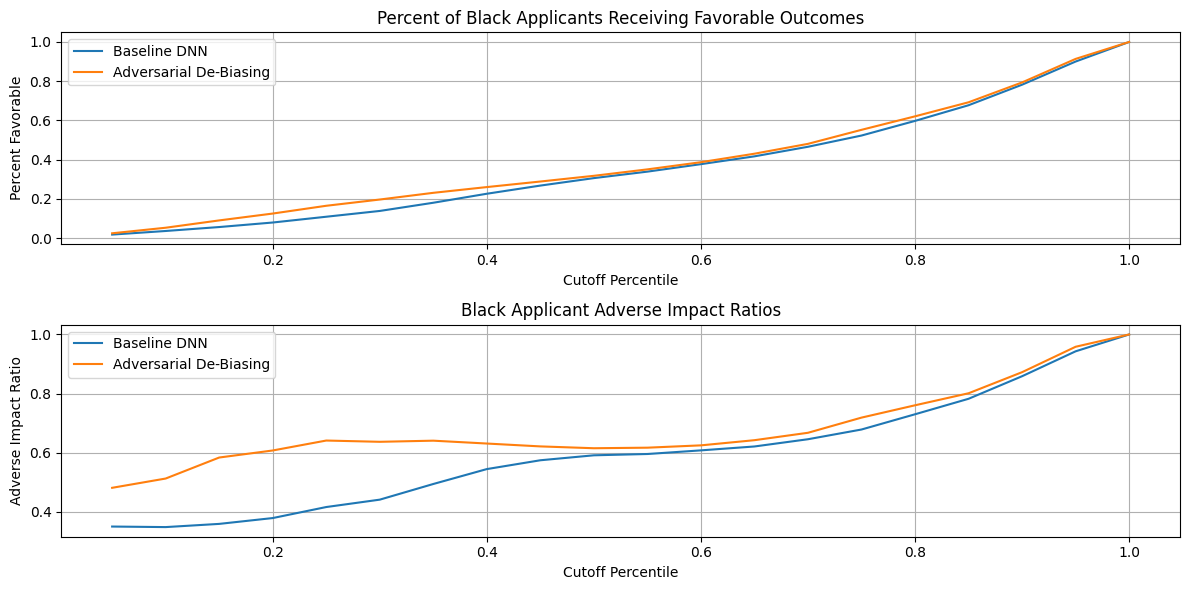

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
quantiles = [x[1] for x in air_compare.index.to_numpy()]

ax[0].plot(quantiles, air_compare[f'Baseline DNN: Pct Favorable'], label='Baseline DNN')
ax[0].plot(quantiles, air_compare[f'Adversarial De-Biasing: Pct Favorable'], label='Adversarial De-Biasing')
ax[0].set_xlabel('Cutoff Percentile')
ax[0].set_ylabel('Percent Favorable')
ax[0].set_title(f'Percent of Black Applicants Receiving Favorable Outcomes')
ax[0].legend()
ax[0].grid()

ax[1].plot(quantiles, air_compare[f'Baseline DNN: AIR'], label='Baseline DNN')
ax[1].plot(quantiles, air_compare[f'Adversarial De-Biasing: AIR'], label='Adversarial De-Biasing')
ax[1].set_xlabel('Cutoff Percentile')
ax[1].set_ylabel('Adverse Impact Ratio')
ax[1].set_title(f'Black Applicant Adverse Impact Ratios')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
air_compare['Percent Increase'] = air_compare['Adversarial De-Biasing: Pct Favorable'] - air_compare['Baseline DNN: Pct Favorable']

mask = (air_compare.reset_index('Quantile')['Quantile'] * 100 % 10 == 0).values
columns = ['Baseline DNN: Pct Favorable', 'Adversarial De-Biasing: Pct Favorable', 'Percent Increase']
air_compare.loc[mask, columns].style.format('{:0.2%}').background_gradient(cmap='coolwarm_r')

## Understanding Why Disparities Decreased in the Adversarial Debiasing Model

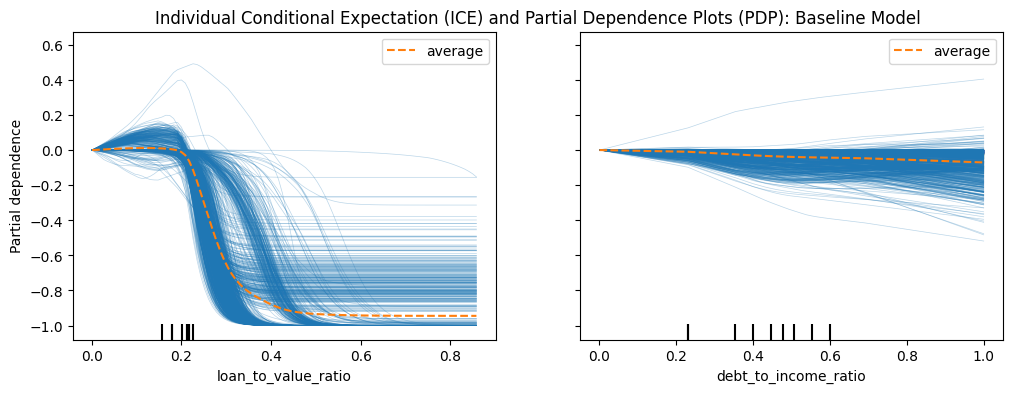

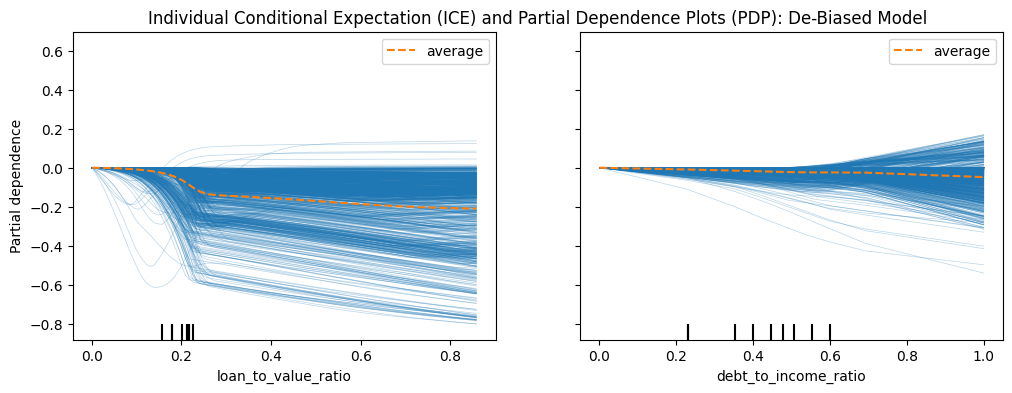

In [ ]:
ice_features = ['loan_to_value_ratio', 'debt_to_income_ratio']
ice_features_index = [i for i, x in enumerate(features) if x in ice_features]

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title('Individual Conditional Expectation (ICE) and Partial Dependence Plots (PDP): Baseline Model')
PartialDependenceDisplay.from_estimator(
    estimator=base_model,
    X=valid[features],
    features=ice_features_index,
    feature_names=features,
    kind='both',
    centered=True,
    ax=ax,
    percentiles=(0., 1.0),
)
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title('Individual Conditional Expectation (ICE) and Partial Dependence Plots (PDP): De-Biased Model')
PartialDependenceDisplay.from_estimator(
    estimator=adb_model,
    X=valid[features],
    features=ice_features_index,
    feature_names=features,
    kind='both',
    centered=True,
    ax=ax,
    percentiles=(0., 1.0),
)
plt.show()

In [ ]:
white_mean_income = df[df['white'] == 1]['income'].mean()
black_mean_income = df[df['black'] == 1]['income'].mean()

white_mean_loan_to_value_ratio = df[df['white'] == 1]['loan_to_value_ratio'].mean()
black_mean_loan_to_value_ratio = df[df['black'] == 1]['loan_to_value_ratio'].mean()


white_mean_debt_to_income_ratio = df[df['white'] == 1]['debt_to_income_ratio'].mean()
black_mean_debt_to_income_ratio = df[df['black'] == 1]['debt_to_income_ratio'].mean()


print("Mean income for 'white' : {:,.2f}".format(white_mean_income))
print("Mean income for 'black' : {:,.2f}".format(black_mean_income))
print()

print("Mean loan to value ratio for 'white' : {:,.2f}".format(white_mean_loan_to_value_ratio))
print("Mean loan to value ratio for 'black' : {:,.2f}".format(black_mean_loan_to_value_ratio))
print()

print("Mean debt to income ratio for 'white' : {:,.2f}".format(white_mean_debt_to_income_ratio))
print("Mean debt to income ration for 'black' : {:,.2f}".format(black_mean_debt_to_income_ratio))

Mean income for 'white' : 169,313.62
Mean income for 'black' : 117,417.54

Mean loan to value ratio for 'white' : 0.87
Mean loan to value ratio for 'black' : 0.94

Mean debt to income ratio for 'white' : 0.37
Mean debt to income ration for 'black' : 0.41
